In [1]:
#import all the neccessary packages
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import my_utils as mu
from IPython import display
import math
import matplotlib.pyplot as plt
%matplotlib inline
print("success")

success


In [2]:
##### TASK 1 #####
#create the batch size neccessary for sampling 
batch_size = 256
#read the dataset using my_utils and create the data loaders
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
print("success")

success


In [3]:
##### TASK 2 #####
#Stem which takes in the images, divides it into patches, and runs it through a function
class Net(torch.nn.Module):
    #Takes as input the number of inputs and the number of hidden layers the backbone starts off with
    #The number of inputs correspond to the size of patches flattened (14x14 = 196)
    #The number of hidden layers can be anything, for simplicity it's kept at 196
    def __init__(self, num_inputs, num_hidden):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        #Defines the linear layer function that is used to trasnform the flattened patch into a feature matrix
        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        
    def forward(self, x):
        #patch & stem
        #unfold creates the patches of size 14x14 (considering images are 28x28 this creates 4 patches per image)
        unfold = torch.nn.Unfold(kernel_size=(14, 14), stride=14)
        #applies the unfolding
        x = unfold(x)
        #tranposes the matrix to ensure compatibility during the calculation (must be AxB dot BxC)
        x = torch.transpose(x, 1, 2)
        #applies the linear function that creates the feature matrix. This will be passed into the backbone
        x = self.Linear1(x)
        return x

#initalises the weights as seen in Week 5 labs according to a guassian normal distribution for the weights, and bias of 0
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

In [4]:
#Backbone is fed the output of stem. This is 1 block
class Backbone(torch.nn.Module):
    #Takes as input the number of hidden layers which is the first layer of the backbone
    #Number of final outputs it will produce
    #And the number of outputs for the remaining layers 
    def __init__(self, num_hidden, num_outputs, L1, L2, L3):
        super(Backbone, self).__init__()
        self.num_outputs = num_outputs
        self.num_hidden = num_hidden
        self.L1 = L1
        self.L3 = L2
        self.L2 = L3
        #4 different linear layers will be required for the backbone
        self.Linear2 = nn.Linear(num_hidden, L1)
        self.Linear3 = nn.Linear(L1, L2)
        self.Linear4 = nn.Linear(L2, L3)
        self.Linear5 = nn.Linear(L3, num_outputs)
        #The activation function that will be used
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x2 = self.Linear2(x) #gives XW by applying the linear function to X
        x2 = self.relu(x2) # gives G(XW) by applying the activation function G
        x2 = self.Linear3(x2) # gives G(XW)W by applying the linear function to the result
        #MLP 2
        x3 = self.Linear4(x2) # 2nd MLP for OW which takes as input the result of the 1st MLP
        x3 = self.relu(x3) # Activation for G(OW)
        x3 = self.Linear5(x3) # G(OW)W for 2nd MLP
        return torch.mean(x3, 1) #returns the mean to be used in the classifier stage

#Similar initialisation used as Stem taken from week 5 labs
def init_weights(m):
    if type(m) == nn.Linear: 
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

In [6]:
#Layer values and outputs are initialised
num_inputs, num_hidden, num_outputs, L1, L2, L3 = 196, 196, 10, 98, 49, 25

#Stem and backbone objects are created. Multiple blocks can be created by creating more instances of Backbone
#Additional layer outputs will have to be initialised as well as an optimiser to match each instance
net = Net(num_inputs, num_hidden)
backbone = Backbone(num_hidden, num_outputs,L1,L2,L3)


In [7]:
########### TASK 3 ############
#Using Cross Entropy loss as seen in week 5 labs
loss = nn.CrossEntropyLoss()
#After trying a few optimisers Adam seemed to give the best values with a lr of 0.004
#Each part of the model requires its own optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=0.004, weight_decay=0)
optimizerb = torch.optim.Adam(backbone.parameters(), lr=0.004, weight_decay=0)

In [8]:
#Taken straight from week 5 to plot the graph
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [9]:
#Taken straight from week 5 to obtain the accuracy 
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, backbone, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        yhat = net(X)
        yhat = backbone(yhat)
        metric.add(accuracy(yhat, y), y.numel())
    return metric[0] / metric[1]

0.8787


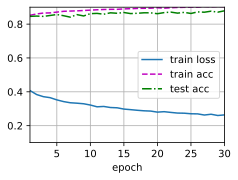

In [12]:
########### TASK 4 ############
#Training code was taken from week 5 labs and modified to work with the model. As there are 2 parts to the model 
#with the stem and backbone, they require their own optimiser to be passed into the training code
#Soft max regression classifier that takes the mean features
def train_epoch_ch3(net, backbone, train_iter, loss, optimizer, optimizerb, batch_size=256, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode for the stem and backbone seperately
    if isinstance(net, torch.nn.Module):
        net.train()
    if isinstance(backbone, torch.nn.Module):
        backbone.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        #first obtains the output of stem
        y_hat = net(X)
        #passes the output of stem to backbone
        #outputs the mean feature which is fed to the classifier
        y_hat = backbone(y_hat)
        #calculates the loss according to the results obtained and predicted
        l = loss(y_hat, y)
        #resets the gradient so it doesn't interfere
        optimizer.zero_grad()
        optimizerb.zero_grad()
        #calculate the gradient
        l.backward()
        #update the weights for both the stem and backbone
        optimizer.step()
        optimizerb.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

#taken from week 5 lab, backbone was added in to the variables so it's passed in and can be used
def train_ch3(net, backbone,train_iter, test_iter, loss, num_epochs, optimizer, optimizerb): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, backbone, train_iter, loss, optimizer, optimizerb)
        test_acc = evaluate_accuracy(net, backbone, test_iter)
        print(test_acc)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics    
    print(test_acc)

#runs through the dataset 30 times
num_epochs = 30
train_ch3(net, backbone,train_iter, test_iter, loss, num_epochs, optimizer, optimizerb)

In [11]:
print("success")

success
